In [7]:
import torch 
from dect.directions import generate_2d_directions 
from dect.ect import compute_ect, compute_ect_gaussianthreshold
from dect.ect_fn import scaled_sigmoid 
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity as sklearn_kde
# !pip install torch-kde
from torchkde import KernelDensity as torch_kde

def average_column_distance(matrix):
    # Transponemos para que las columnas pasen a ser vectores fila
    columns = matrix.T  # shape: (m, n)
    
    # Calculamos matriz de distancias euclídeas entre columnas
    dists = torch.cdist(columns.unsqueeze(0), columns.unsqueeze(0)).squeeze(0)
    
    # Ignoramos la diagonal (autodistancias = 0)
    mask = ~torch.eye(dists.size(0), dtype=bool)
    return dists[mask].mean()

Compute the ect for a point cloud, in this case we are just considering points vertex (0d-simplices). Actually, it is calculated in a random equidistant way according the thresholds are used for compute it. More specifically:

```python
lin = torch.linspace(-radius, radius, resolution, device=x.device).view(-1, 1, 1) # resolution is the number of thresholds, for example 64
```

You can check it at the github repository of DECT library, more specifically in line 98 for example for ect.py file. https://github.com/aidos-lab/dect/blob/main/dect/ect.py.

I have added a modification in the code to return the threshold vector and to select it using gaussian kernel estimation:

```python
from torchkde import KernelDensity
def compute_ect_gaussianthreshold(
    x: Tensor,
    *simplices,
    v: Tensor,
    radius: float,
    resolution: int,
    scale: float,
    index: Tensor | None = None,
    ect_fn: Callable[..., Tensor] = indicator,
) -> Tensor:

    # ecc.shape[0], index.max().item() + 1, ecc.shape[2],
    if index is not None:
        batch_len = int(index.max() + 1)
    else:
        batch_len = 1
        index = torch.zeros(size=(len(x),), dtype=torch.int32)

    # v is of shape [d, num_thetas]
    num_thetas = v.shape[1]

    out_shape = (resolution, batch_len, num_thetas)

    # Node heights have shape [num_points, num_directions]
    nh = x @ v
    th = torch.linspace(-radius, radius, resolution).view(-1, 1, 1)
    KernelDensityTorch = KernelDensity(kernel='gaussian', bandwidth=1.0*th.squeeze().std()).fit(th.squeeze().reshape(-1, 1))
    lin, indices=torch.sort(KernelDensityTorch.sample(resolution).squeeze(), descending=False)
    lin = lin.view(-1, 1, 1)
    ecc = ect_fn(scale * torch.sub(lin, nh))

    output = torch.zeros(
        size=out_shape,
        device=nh.device,
    )

    output.index_add_(1, index, ecc)

    # For the calculation of the edges, loop over the simplex tensors.
    # Each index tensor is assumed to be of shape [d,num_simplices],
    # where d is the dimension of the simplex.
    for i, simplex in enumerate(simplices):
        # Simplex heights.
        sh, _ = nh[simplex].max(dim=0)

        # Compute which batch an edge belongs to. We take the first index of the
        # edge (or faces) and do a lookup on the batch index of that node in the
        # batch indices of the nodes.
        index_simplex = index[simplex[0]]

        # Calculate the ECC of the simplices.
        secc = (-1) ** (i + 1) * ect_fn(scale * torch.sub(lin, sh))

        # Add the ECC of the simplices to the running total.
        output.index_add_(1, index_simplex, secc)

    # Returns the ect as [batch_len, num_thetas, resolution]
    return output.movedim(0, 1).movedim(-1, -2), lin
```

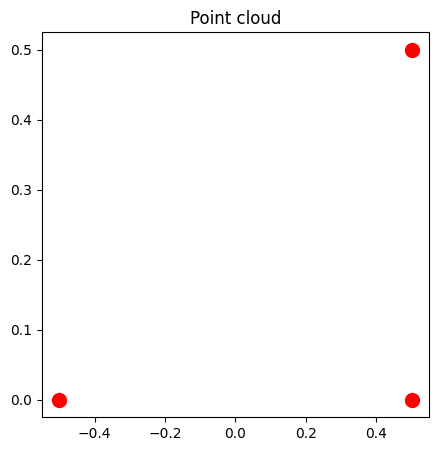

In [3]:
# Basic dataset with three points,three edges and one face.
points_coordinates = torch.tensor([[0.5, 0.0], [-0.5, 0.0], [0.5, 0.5]])

# Convertir a NumPy para graficar con Matplotlib
points_np = points_coordinates.numpy()

x_vals, y_vals = points_np[:, 0], points_np[:, 1]

# Crear la figura
plt.figure(figsize=(5, 5))
plt.scatter(x_vals, y_vals, color='red', marker='o', s=100, label="Puntos")
# Configurar el gráfico
plt.title("Point cloud")
plt.show()

# Generate a set of structured directions along the unit circle.
v = generate_2d_directions(num_thetas=64)

[-1.         -0.96825397 -0.93650794 -0.9047619  -0.8730159  -0.84126985
 -0.8095238  -0.7777778  -0.74603176 -0.71428573 -0.6825397  -0.6507937
 -0.6190476  -0.58730155 -0.5555555  -0.5238095  -0.49206346 -0.46031743
 -0.4285714  -0.39682537 -0.36507934 -0.3333333  -0.30158728 -0.26984125
 -0.23809516 -0.20634913 -0.1746031  -0.14285707 -0.11111104 -0.07936502
 -0.04761899 -0.01587296  0.01587296  0.04761899  0.07936502  0.11111104
  0.14285707  0.1746031   0.20634913  0.23809516  0.26984125  0.30158728
  0.3333333   0.36507934  0.39682537  0.4285714   0.46031743  0.49206346
  0.5238095   0.5555555   0.58730155  0.6190476   0.6507937   0.6825397
  0.71428573  0.74603176  0.7777778   0.8095238   0.84126985  0.8730159
  0.9047619   0.93650794  0.96825397  1.        ]


c:\Users\cimagroup\Documents\Repositorios\EulerCharacteristicTransform_Tutorial\env\lib\site-packages\torchkde\modules.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.tree_.data)


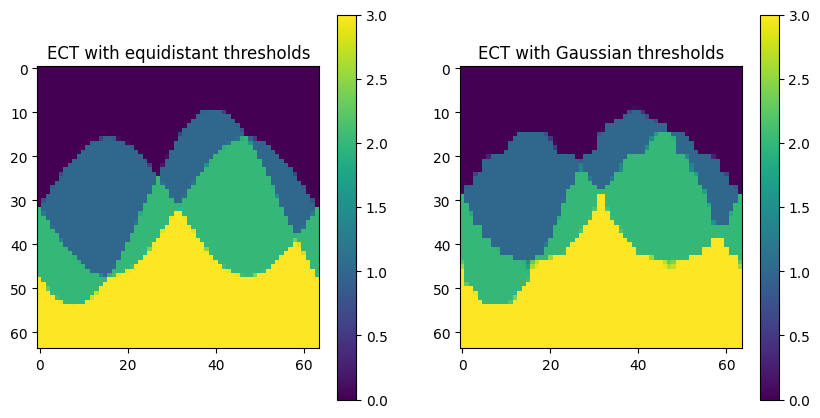

In [4]:
# Compute the ECT.
ect,thresholds = compute_ect(
    points_coordinates, 
    v=v,
    radius=1,
    resolution=64,
    scale=500,
    ect_fn=scaled_sigmoid
)

thresholdsSqueeze = thresholds.detach().squeeze().numpy()
print(thresholdsSqueeze) # we can see that the thresholds are effectively equidistant.

ectGaussianTh,thresholdsGaussian = compute_ect_gaussianthreshold(
    points_coordinates, 
    v=v,
    radius=1,
    resolution=64,
    scale=500,
    ect_fn=scaled_sigmoid
)

# Comparing both ect
fig,axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("ECT with equidistant thresholds")
im0=axes[0].imshow(ect.detach().squeeze().numpy().T)
fig.colorbar(im0, ax=axes[0])

axes[1].set_title("ECT with Gaussian thresholds")
im1=axes[1].imshow(ectGaussianTh.detach().squeeze().numpy().T)
fig.colorbar(im1, ax=axes[1])
plt.show()

In [9]:
dist_ectNormal = average_column_distance(ect.squeeze())
dist_ectGaussianTH = average_column_distance(ectGaussianTh.squeeze())

print(f"Mean distance between columns in Normal ECT: {dist_ectNormal.item():.4f}")
print(f"Mean distance between columns in ECT using KDE for threshold selection: {dist_ectGaussianTH.item():.4f}")

Mean distance between columns in Normal ECT: 11.4987
Mean distance between columns in ECT using KDE for threshold selection: 11.4623


Comparing KDE functions of different libraries. We have used the one implement in torch, by torch-kde librart

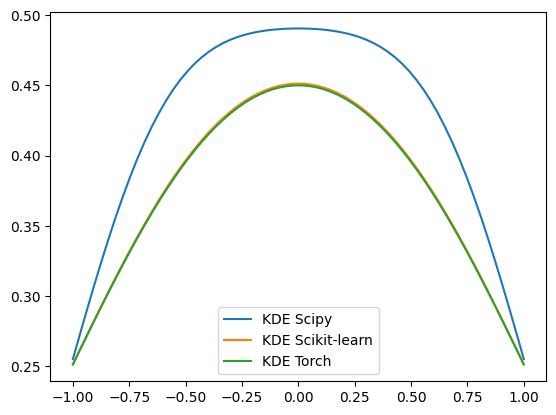

In [5]:
KernelDensityScipy = gaussian_kde(thresholdsSqueeze, bw_method=1.0*thresholdsSqueeze.std())
kde_scipy = KernelDensityScipy.pdf(thresholdsSqueeze)

KernelDensityScikit = sklearn_kde(kernel='gaussian', bandwidth=1.0*thresholdsSqueeze.std()).fit(thresholdsSqueeze.reshape(-1, 1))
kde_sk = np.exp(KernelDensityScikit.score_samples(thresholdsSqueeze.reshape(-1, 1)))

KernelDensityTorch = torch_kde(kernel='gaussian', bandwidth=1.0*thresholds.squeeze().std()).fit(thresholds.squeeze().reshape(-1, 1))
kde_torch = torch.exp(KernelDensityTorch.score_samples(thresholds.squeeze().reshape(-1, 1))).detach().numpy()

plt.plot(thresholdsSqueeze, kde_scipy, label='KDE Scipy')
plt.plot(thresholdsSqueeze, kde_sk, label='KDE Scikit-learn')
plt.plot(thresholdsSqueeze, kde_torch, label='KDE Torch')
plt.legend()
plt.show()

c:\Users\cimagroup\Documents\Repositorios\EulerCharacteristicTransform_Tutorial\env\lib\site-packages\torchkde\modules.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.tree_.data)


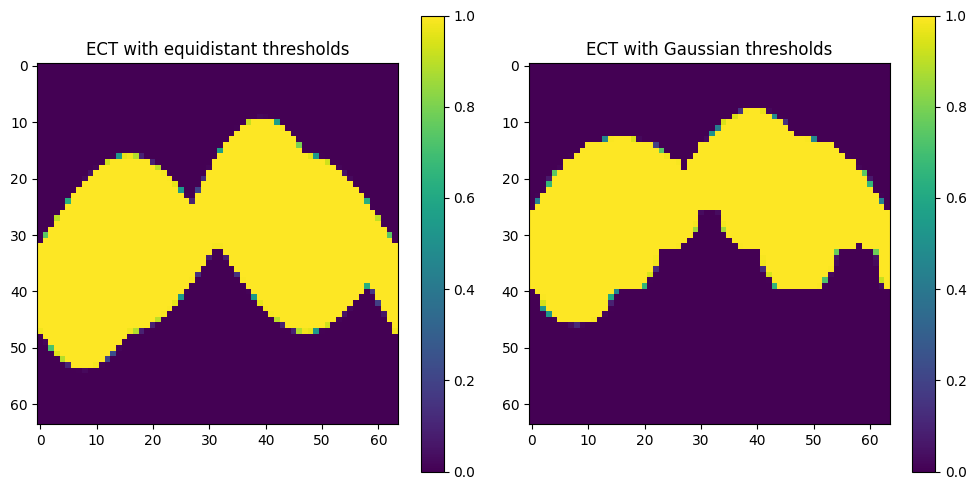

In [6]:
# For a graph
torch.manual_seed(42) 

points_coordinates = torch.tensor([[0.5, 0.0], [-0.5, 0.0], [0.5, 0.5]])
edge_index=torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)

ectGraphNormal,thresholdsGaussian = compute_ect(
    points_coordinates,
    edge_index, 
    v=v,
    radius=1,
    resolution=64,
    scale=500,
    ect_fn=scaled_sigmoid
)


ectGraphGaussianTh,thresholdsGaussian = compute_ect_gaussianthreshold(
    points_coordinates,
    edge_index, 
    v=v,
    radius=1,
    resolution=64,
    scale=500,
    ect_fn=scaled_sigmoid
)

# Comparing both ect
fig,axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("ECT with equidistant thresholds")
im0=axes[0].imshow(ectGraphNormal.detach().squeeze().numpy().T)
fig.colorbar(im0, ax=axes[0])
# Visualize as an image.
axes[1].set_title("ECT with Gaussian thresholds")
im1=axes[1].imshow(ectGraphGaussianTh.detach().squeeze().numpy().T)
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

We see which ect has more distance between their columns

In [8]:
dist_ectGraphNormal = average_column_distance(ectGraphNormal.squeeze())
dist_ectGraphGaussianTH = average_column_distance(ectGraphGaussianTh.squeeze())

print(f"Mean distance between columns in Normal ECT: {dist_ectGraphNormal.item():.4f}")
print(f"Mean distance between columns in ECT using KDE for threshold selection: {dist_ectGraphGaussianTH.item():.4f}")

Mean distance between columns in Normal ECT: 4.8983
Mean distance between columns in ECT using KDE for threshold selection: 4.5849
